In [1]:
import pycns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
from configuration import *
from icp_jobs import *

# ICP CHAN NAMES

In [9]:
for sub in subs:
    cns_reader = pycns.CnsReader(data_path / sub)
    stream_names = list(cns_reader.streams.keys())
    stream_with_P = [name for name in stream_names if ('P' in name and len(name) < 4)]
    stream_with_P = [n for n in stream_with_P if not n in ['CPP','ABP']]
    print(sub, stream_with_P)

Patient_2024_May_16__9_33_08_427295 ['P1', 'P2']
Patient_2024_May_25__16_48_44_716049 ['P1', 'P']
Patient_2024_May_25__16_09_03_881877 ['ICP', 'P1']
Patient_2024_Jun_24__12_33_38_160174 ['ICP', 'P1', 'P']
PatientData_1723890119868125 ['ICP', 'P1', 'P']


# PSI PLOT

/tmp/ipykernel_367519/1979120669.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


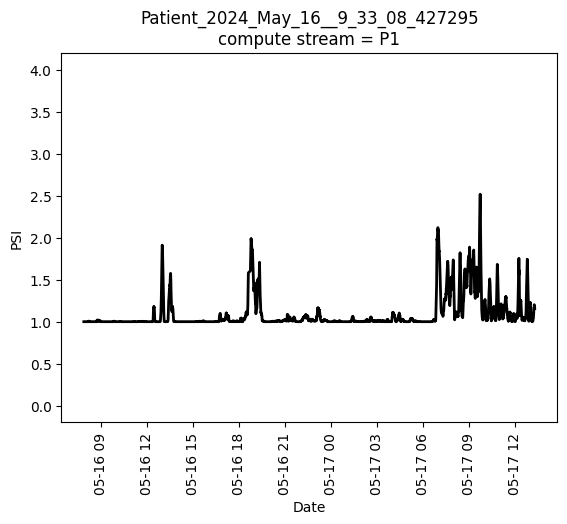

/tmp/ipykernel_367519/1979120669.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


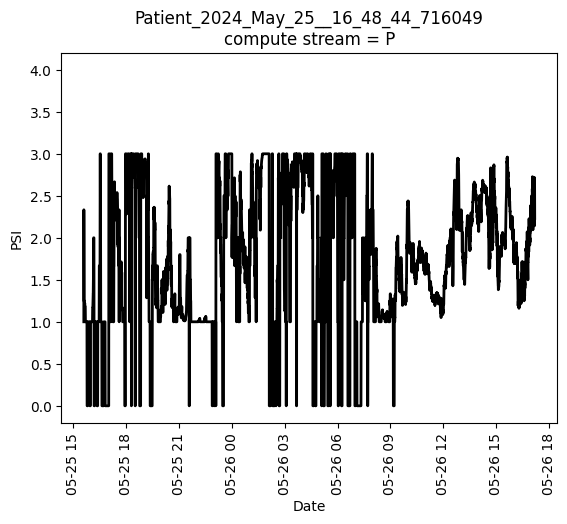

/tmp/ipykernel_367519/1979120669.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


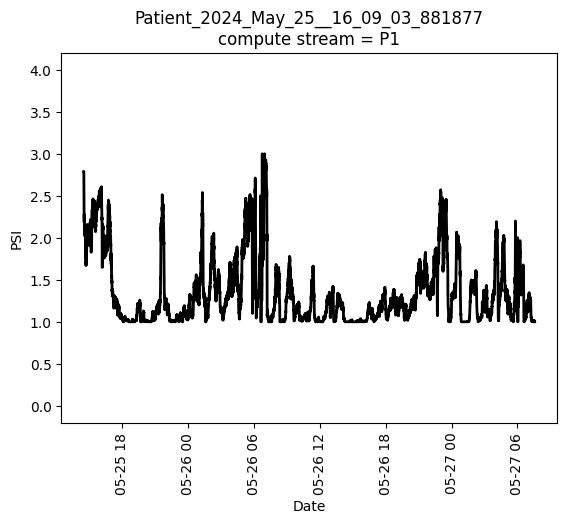

/tmp/ipykernel_367519/1979120669.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


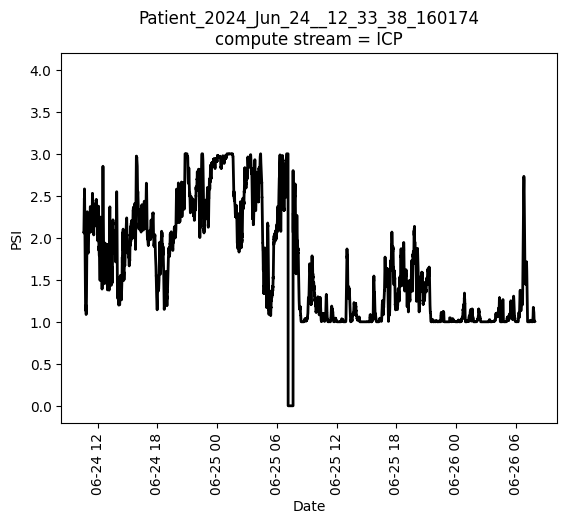

/tmp/ipykernel_367519/1979120669.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


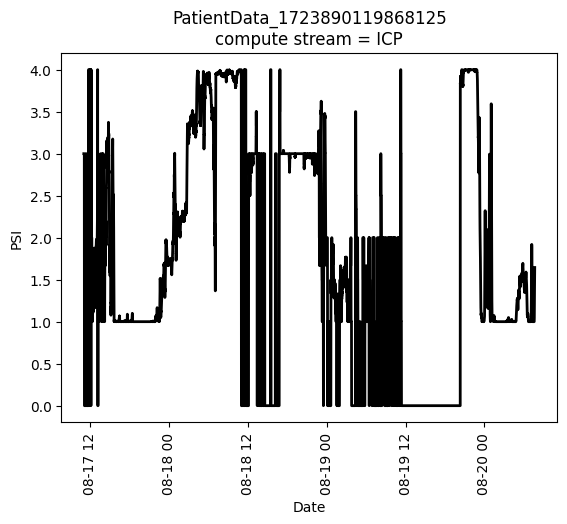

In [33]:
for sub in subs:
    da_psi = psi_job.get(sub)['psi']
    compute_stream = icp_chan_name[sub]
    fig, ax = plt.subplots()
    ax.set_ylabel('PSI')
    ax.set_xlabel('Date')
    ax.set_ylim(-0.2, 4.2)
    ax.plot(da_psi['date'], da_psi.values, color='k', lw = 2)
    ax.set_title(f'{sub}\ncompute stream = {compute_stream}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    fig.savefig(base_folder / 'results' / 'psi' / f'{sub}.png', dpi = 200, bbox_inches = 'tight')
    plt.show()

# SIGNAL SAMPLE PLOT

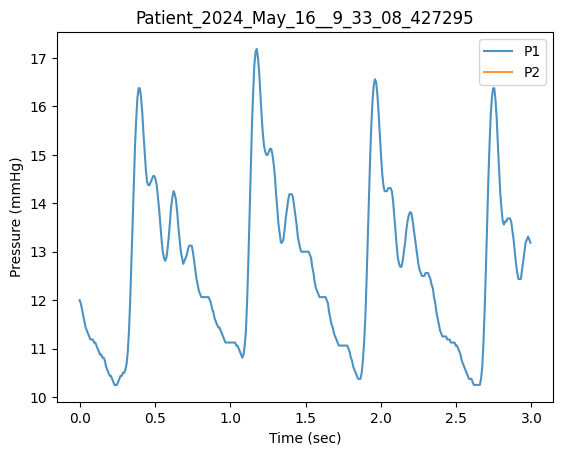

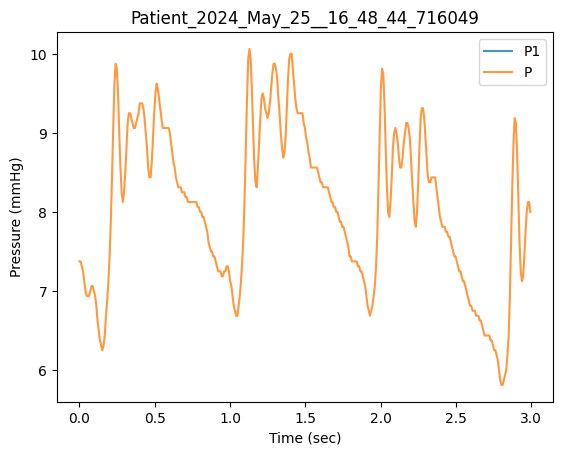

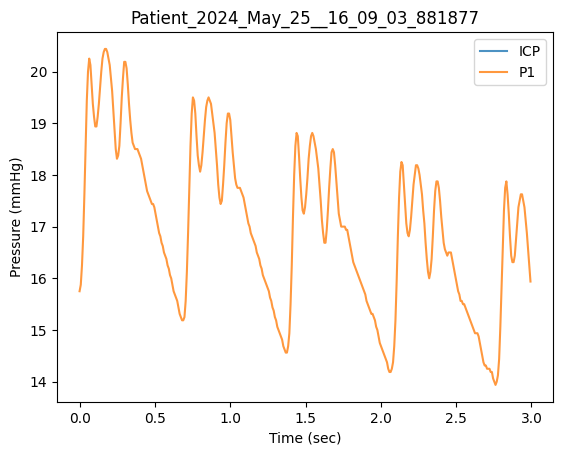

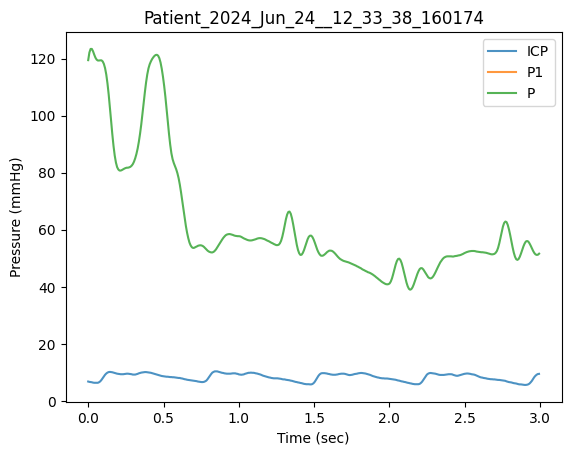

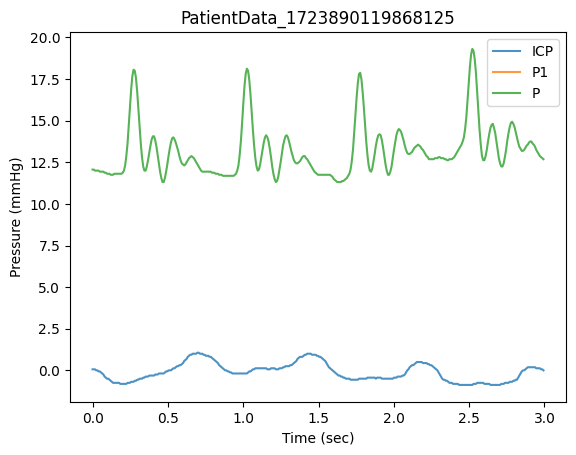

In [30]:
sec_start = 3600
duration_secs = 3

sec_stop =  sec_start + duration_secs
for sub in subs:
    cns_reader = pycns.CnsReader(data_path / sub)
    stream_names = list(cns_reader.streams.keys())
    stream_with_P = [name for name in stream_names if ('P' in name and len(name) < 4)]
    stream_with_P = [n for n in stream_with_P if not n in ['CPP','ABP']]
    
    fig, ax = plt.subplots()
    ax.set_title(sub)
    for stream_name in stream_with_P:
        stream = cns_reader.streams[stream_name]
        srate = stream.sample_rate
        raw_icp = stream.get_data(isel = slice(int(sec_start * srate), int(srate * sec_stop)), apply_gain=True)
        t = np.arange(raw_icp.size) / srate
        ax.plot(t, raw_icp, label = stream_name, alpha = 0.8)
    ax.set_ylabel('Pressure (mmHg)')
    ax.set_xlabel('Time (sec)')
    ax.legend() 
    # fig.savefig(base_folder / 'results' / 'sample_signal' / f'{sub}_sec_start{sec_start}.png', dpi = 200, bbox_inches = 'tight')
    plt.show()

# PULSE WAVEFORM 

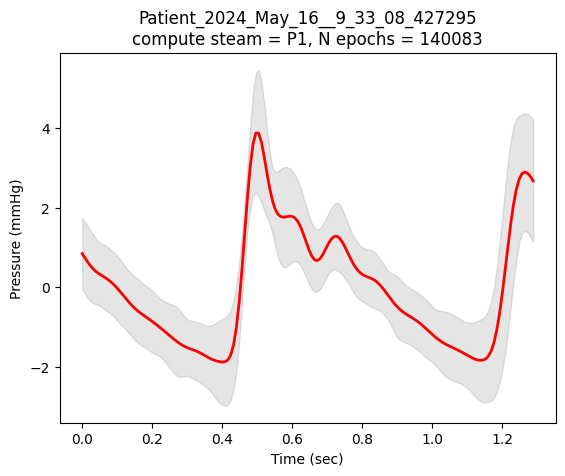

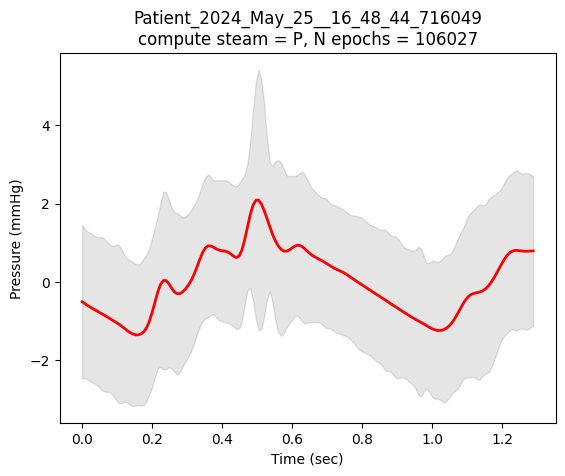

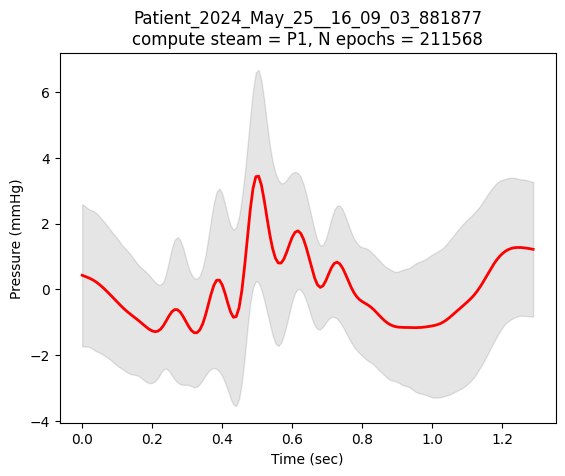

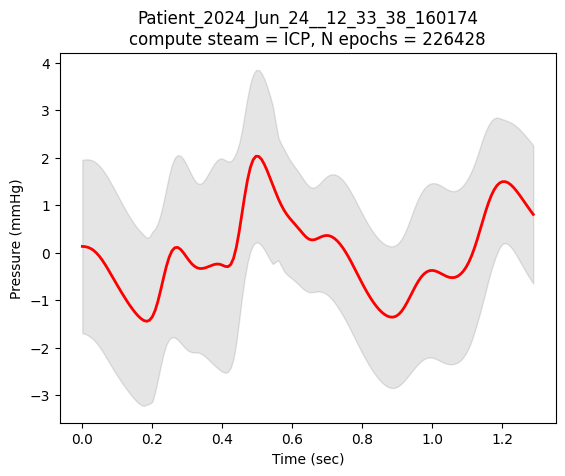

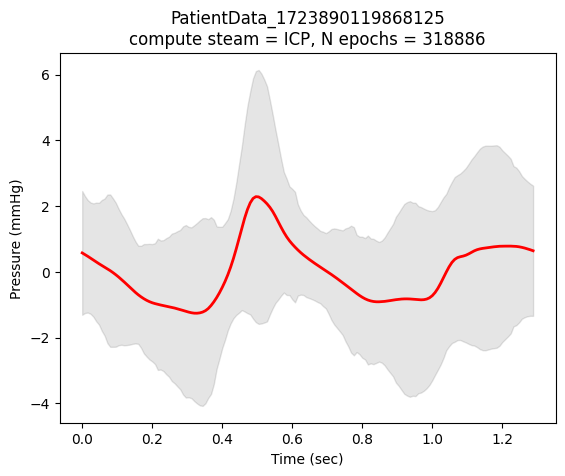

In [2]:
secs_before_peak = 0.5
secs_after_peak = 0.8

win_duration_secs = secs_before_peak + secs_after_peak

for sub in subs:
    stream_name = icp_chan_name[sub]
    cns_reader = pycns.CnsReader(data_path / sub)
    stream = cns_reader.streams[stream_name]
    srate = stream.sample_rate
    raw_icp , dates = stream.get_data(with_times = True, apply_gain = True)

    icp_detections = detect_icp_job.get(sub).to_dataframe()
    n_epochs = icp_detections.shape[0]
    epochs = None
    for i, row in icp_detections.iterrows():
        peak_time = row['peak_time']
        win_start_s = peak_time - secs_before_peak
        win_start_ind = int(win_start_s * srate)
        win_stop_ind = win_start_ind + int(win_duration_secs * srate)
        epoch = raw_icp[win_start_ind:win_stop_ind]

        if epochs is None:
            epochs = np.zeros((n_epochs, epoch.size))
        epochs[i,:] = epoch

    epochs = epochs - np.mean(epochs, axis = 1)[:,None]
    m = np.mean(epochs, axis = 0)
    s = np.std(epochs, axis = 0)
    t = np.arange(m.size) / srate

    fig, ax = plt.subplots()
    ax.plot(t, m, color = 'r', lw = 2)
    ax.fill_between(t, m-s, m+s, color = 'k', alpha = 0.1)
    ax.set_ylabel('Pressure (mmHg)')
    ax.set_xlabel('Time (sec)')
    ax.set_title(f'{sub}\ncompute steam = {stream_name}, N epochs = {n_epochs}')
    fig.savefig(base_folder / 'results' / 'pulse_waveform' / f'{sub}.png', dpi = 200, bbox_inches = 'tight')
    plt.show()  

